# Time Series Fundamentals

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt

In [2]:
#get data
data_path = 'BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'
bitcoin_df = pd.read_csv(data_path, parse_dates=['Date'], index_col=['Date'])
print(f'length : {len(bitcoin_df)} row')
bitcoin_df.head(10)

length : 2787 row


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266


In [3]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
#only want closing price
bitcoin_prices = pd.DataFrame({'Price':bitcoin_df['Closing Price (USD)']})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


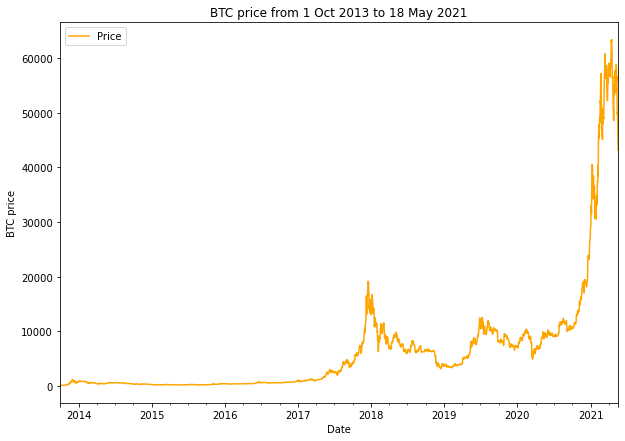

In [5]:
bitcoin_prices.plot(figsize=(10,7), color='orange')
plt.ylabel('BTC price')
plt.title('BTC price from 1 Oct 2013 to 18 May 2021');

## Create train and test set
time seris : use past feature to predict the future

In [6]:
times = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

train_size = int(len(times) *.8)
X_train, y_train = times[:train_size], prices[:train_size]
X_test, y_test = times[train_size:], prices[train_size:]

X_train.shape, X_test.shape , len(times)

((2229,), (558,), 2787)

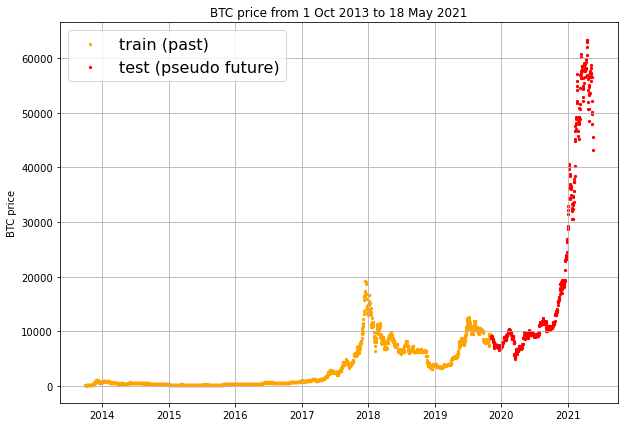

In [7]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, c='orange', label='train (past)')
plt.scatter(X_test, y_test, s=5, c='red', label='test (pseudo future)')
plt.legend(fontsize=16)
plt.grid(True)
plt.ylabel('BTC price')
plt.title('BTC price from 1 Oct 2013 to 18 May 2021');

## Model 0 | Naive forecast
in formular : $$\hat{y}_{t} = y_{t-1}$$

the prediction at timestep t(y-hat) is equal to the value at timestep t-1 (previous timestep) - for horizon of 1

**For example**, suppose we have the following sales of a given product during the first three months of the year:

<img src="https://www.statology.org/wp-content/uploads/2020/12/naive_forecast2-300x181.png"/>

The forecast for sales in April would simply be equal to the actual sales from the previous month of March:

*Although this method is simple, it tends to work surprisingly well in practice.*

In [8]:
#create Naive forecast
naive_forecast = y_test[:-1]
print('forecast :',naive_forecast[-4:])
print('actual :',y_test[-4:])

forecast : [49764.1320816  50032.69313676 47885.62525472 45604.61575361]
actual : [50032.69313676 47885.62525472 45604.61575361 43144.47129086]


### MASE (Mean Absolute Scaled Error) 
for time series forcasting metrics

metric that allows you to compare two models. Using the MAE for each model, If the MASE value is less than 1, then the new model performs better. If the MASE value is greater than 1, then the original model performed better than the new model.

<img src="https://miro.medium.com/max/964/1*hImatS5n4JjrAP09f0qduQ.png"/>

In [9]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    """
    mae = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive # original model is naive forcast

In [10]:
mean_absolute_scaled_error(y_test[1:], naive_forecast)

0.9995699939182626

In [11]:
#create evaluate metrics
def evaluate_score(y_true, y_pred) :
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean(np.square(y_true - y_pred))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred )/y_true)) # Mean absolute percentage error
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        'mape':mape,
        'mase':mase
    }

In [12]:
naive_score = evaluate_score(y_test[1:], naive_forecast)
naive_score

{'mae': 567.9802273457542,
 'mse': 1147547.125023896,
 'rmse': 1071.2362601330744,
 'mape': 0.02516524929982267,
 'mase': 0.9995699939182626}

### windowing our dataset
to turn data into a supervised learning problem

windowing for 1 week:<br>
[0, 1, 2, 3, 4, 5, 6] -> [7]<br>
[1, 2, 3, 4, 5, 6, 7] -> [8]

In [13]:
print(prices[:7] ,'->',prices[7])

[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> 123.033


In [14]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [15]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [16]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange( len(x)-(window_size+horizon-1) ), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [17]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [18]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_size=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  train_size = int(len(windows) * (1-test_size)) # this will default to 80% train/20% test
  train_windows = windows[:train_size]
  train_labels = labels[:train_size]
  test_windows = windows[train_size:]
  test_labels = labels[train_size:]
  return train_windows, test_windows, train_labels, test_labels

In [19]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Create ModelCheckpoint

In [20]:
def crete_model_checkpoint(model_name, save_path='model_experiment'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), save_best_only=True, monitor='val_loss')

## Model 1 : Dense Model (window = 7, horizon = 1)

In [21]:
tf.random.set_seed(42)
inputs = keras.Input(shape=(7,), name='input_layers')
x = keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(1)(x)
model_1 = keras.Model(inputs, outputs, name='dense_model')

model_1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_1 = model_1.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=1, callbacks=[crete_model_checkpoint(model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 121ms/step - loss: 780.3469 - mae: 780.3469 - mse: 2312739.0000 - val_loss: 2279.5833 - val_mae: 2279.5833 - val_mse: 12772098.0000
Epoch 2/100
18/18 [==============================] - 1s 69ms/step - loss: 247.6765 - mae: 247.6765 - mse: 285480.9375 - val_loss: 1005.9865 - val_mae: 1005.9865 - val_mse: 3441760.2500
Epoch 3/100
18/18 [==============================] - 1s 80ms/step - loss: 188.4107 - mae: 188.4107 - mse: 171890.0156 - val_loss: 923.2859 - val_mae: 923.2859 - val_mse: 2868195.0000
Epoch 4/100
18/18 [==============================] - 1s 77ms/step - loss: 169.4334 - mae: 169.4334 - mse: 151699.4531 - val_loss: 900.5932 - val_mae: 900.5932 - val_mse: 2683713.5000
Epoch 5/100
18/18 [==============================] - 1s 83ms/step - loss: 165.0899 - mae: 165.0899 - mse: 145490.8750 - val_loss: 895.2404 - val_mae: 895.2404 - val_mse: 2564605.7500
Epoch 6/100
18/18 [==============================] - 1s 71ms/step - loss: 158.

In [22]:
model_1.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 662.5316 - mae: 662.5316 - mse: 1358190.3750


[662.5316162109375, 662.5316162109375, 1358190.375]

In [24]:
#load the save best performing model
model_1 = keras.models.load_model('model_experiment/dense_model')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 568.5499 - mae: 568.5499 - mse: 1172587.7500


[568.5499267578125, 568.5499267578125, 1172587.75]

In [25]:
predictions = model_1.predict(test_windows).reshape(-1,)
predictions[:10]

array([8874.493, 8789.944, 9040.987, 8804.829, 8741.212, 8749.836,
       8705.866, 8513.171, 8478.417, 8536.302], dtype=float32)

In [26]:
model_1_score = evaluate_score(test_labels.reshape(-1,), predictions)
model_1_score

{'mae': 568.5498587262708,
 'mse': 1172587.9917035494,
 'rmse': 1082.8610214166679,
 'mape': 0.025492293493015787,
 'mase': 0.9987845236174441}

In [27]:
def plot_preds(y_true, y_pred, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.grid(True)
    plt.scatter(np.arange(len(y_true)), y_true, s=5, color='blue',label='True')
    plt.plot(np.arange(len(y_true)), y_pred, color='orange',label='Prediction')
    plt.axis([400, 500, 30000, 50000]);
    plt.legend()

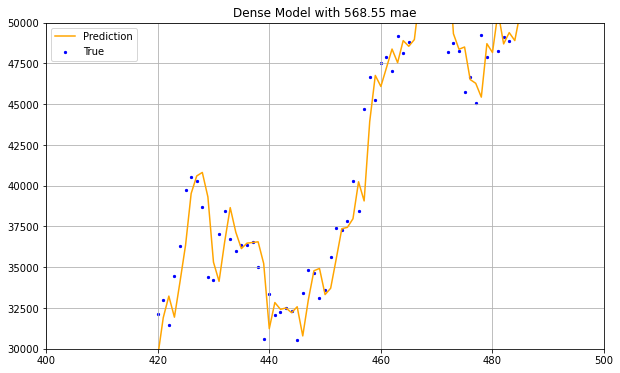

In [28]:
plot_preds(test_labels, predictions, 'Dense Model with 568.55 mae')

## Model 2 : window = 30, horizon = 1

In [29]:
full_windows, full_labels = make_windows(prices, 30, 1)
train_windows, test_windows, train_labels, test_labels =  make_train_test_splits(full_windows, full_labels) 
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [30]:
inputs = keras.Input(shape=(30,), name='input_layers')
x = keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(1)(x)
model_2 = keras.Model(inputs, outputs, name='model_2_30_windows')

model_2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_2 = model_2.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=1, callbacks=[crete_model_checkpoint(model_2.name)])
model_2.summary()

Epoch 1/100
18/18 [==============================] - 1s 50ms/step - loss: 1355.7559 - mae: 1355.7559 - mse: 7234175.5000 - val_loss: 3228.8564 - val_mae: 3228.8564 - val_mse: 25151150.0000
Epoch 2/100
18/18 [==============================] - 1s 60ms/step - loss: 440.8286 - mae: 440.8286 - mse: 832473.7500 - val_loss: 2100.4729 - val_mae: 2100.4729 - val_mse: 11995920.0000
Epoch 3/100
18/18 [==============================] - 1s 49ms/step - loss: 324.9293 - mae: 324.9293 - mse: 479839.5000 - val_loss: 1438.3204 - val_mae: 1438.3204 - val_mse: 6253627.5000
Epoch 4/100
18/18 [==============================] - 1s 52ms/step - loss: 276.6092 - mae: 276.6092 - mse: 356049.1562 - val_loss: 1328.4358 - val_mae: 1328.4358 - val_mse: 5300945.5000
Epoch 5/100
18/18 [==============================] - 1s 39ms/step - loss: 235.3226 - mae: 235.3226 - mse: 267395.5625 - val_loss: 1205.6249 - val_mae: 1205.6249 - val_mse: 4397597.0000
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - los

In [31]:
print(model_2.evaluate(test_windows, test_labels))
model_2 = keras.models.load_model('model_experiment\model_2_30_windows')
print(model_2.evaluate(test_windows, test_labels))

18/18 [==============================] - 0s 1ms/step - loss: 628.4879 - mae: 628.4879 - mse: 1308525.3750
[628.4879150390625, 628.4879150390625, 1308525.375]
18/18 [==============================] - 0s 1ms/step - loss: 605.8221 - mae: 605.8221 - mse: 1256325.6250
[605.8221435546875, 605.8221435546875, 1256325.625]


In [32]:
predictions = model_2.predict(test_windows)

In [33]:
model_2_score = evaluate_score(test_labels, predictions)
model_2_score

{'mae': 605.8219199093379,
 'mse': 1256325.3862984583,
 'rmse': 1120.8592178763836,
 'mape': 0.02738648223843513,
 'mase': 1.058982572095659}

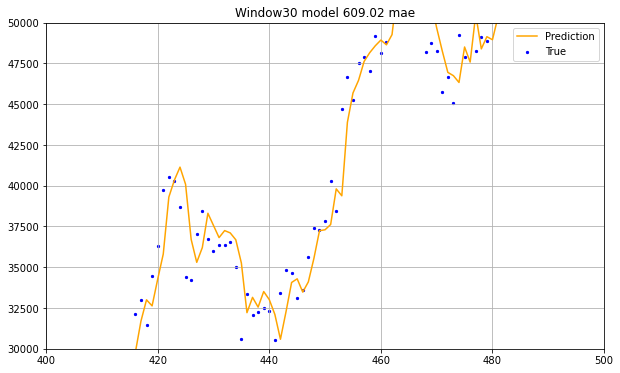

In [34]:
plot_preds(test_labels, predictions, 'Window30 model 609.02 mae')

## Model 3 : Dense (window = 30, horizon = 7)

In [35]:
full_windows, full_labels = make_windows(prices, 30, 7)
train_windows, test_windows, train_labels, test_labels =  make_train_test_splits(full_windows, full_labels) 
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [36]:
inputs = keras.Input(shape=(30,), name='input_layers')
x = keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(7)(x)
model_3 = keras.Model(inputs, outputs, name='model_3_30_windows_7_horizon')

model_3.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_3 = model_3.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=1, callbacks=[crete_model_checkpoint(model_3.name)])
model_3.summary()

Epoch 1/100
18/18 [==============================] - 1s 53ms/step - loss: 1195.6028 - mae: 1195.6028 - mse: 6878233.0000 - val_loss: 2683.7490 - val_mae: 2683.7490 - val_mse: 18011476.0000
Epoch 2/100
18/18 [==============================] - 1s 40ms/step - loss: 480.9726 - mae: 480.9726 - mse: 1099137.0000 - val_loss: 2431.5945 - val_mae: 2431.5945 - val_mse: 18086092.0000
Epoch 3/100
18/18 [==============================] - 1s 50ms/step - loss: 398.5110 - mae: 398.5110 - mse: 800987.3750 - val_loss: 2046.8813 - val_mae: 2046.8813 - val_mse: 12697357.0000
Epoch 4/100
18/18 [==============================] - 1s 41ms/step - loss: 359.2373 - mae: 359.2373 - mse: 660786.3750 - val_loss: 1832.0841 - val_mae: 1832.0841 - val_mse: 10428001.0000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 327.4300 - mae: 327.4300 - mse: 560272.5625 - val_loss: 1893.1785 - val_mae: 1893.1785 - val_mse: 10645451.0000
Epoch 6/100
18/18 [==============================] - 1s 46ms/step -

In [37]:
print(model_3.evaluate(test_windows, test_labels))
model_3 = keras.models.load_model('model_experiment\model_3_30_windows_7_horizon')
print(model_3.evaluate(test_windows, test_labels))

18/18 [==============================] - 0s 2ms/step - loss: 1332.2166 - mae: 1332.2166 - mse: 5760177.5000
[1332.216552734375, 1332.216552734375, 5760177.5]
18/18 [==============================] - 0s 939us/step - loss: 1239.5652 - mae: 1239.5652 - mse: 5318222.5000
[1239.565185546875, 1239.565185546875, 5318222.5]


In [38]:
predictions = model_3.predict(test_windows)

In [39]:
model_3_score = evaluate_score(test_labels, predictions)
model_3_score

{'mae': 1239.565295617795,
 'mse': 5318222.632198564,
 'rmse': 2306.1271934129227,
 'mape': 0.055767308463439594,
 'mase': 2.2057369643163485}

## Model 4 : Conv1D (window = 7, horizon = 1)

In [40]:
full_windows, full_labels = make_windows(prices, 7, 1)
train_windows, test_windows, train_labels, test_labels =  make_train_test_splits(full_windows, full_labels) 
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [41]:
inputs = keras.Input(shape=(7,), name='input_layers')
x = keras.layers.Lambda(lambda z : tf.expand_dims(z, axis=1))(inputs) # expand to 2D array 
x = keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal')(x)
x = keras.layers.Dense(32)(x)
outputs = keras.layers.Dense(1)(x)
model_4 = keras.Model(inputs, outputs, name='model_4_conv1D')

model_4.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_4 = model_4.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=0, callbacks=[crete_model_checkpoint(model_4.name)])

INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiment\model_4_conv1D\assets
INFO:tensorflow:Assets written to: mod

In [42]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 7)]               0         
                                                                 
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 32)             4128      
                                                                 
 dense_7 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [43]:
print(model_4.evaluate(test_windows, test_labels))
model_4 = keras.models.load_model('model_experiment\model_4_conv1D')
print(model_4.evaluate(test_windows, test_labels))

18/18 [==============================] - 0s 2ms/step - loss: 572.1379 - mae: 572.1379 - mse: 1172796.8750
[572.137939453125, 572.137939453125, 1172796.875]
18/18 [==============================] - 0s 2ms/step - loss: 565.3553 - mae: 565.3553 - mse: 1160503.5000
[565.3552856445312, 565.3552856445312, 1160503.5]


In [44]:
y_preds = model_4.predict(test_windows).reshape(-1,1) #shape must be the same

In [45]:
model_4_score = evaluate_score(test_labels, y_preds) 
model_4_score

{'mae': 565.3552816931804,
 'mse': 1160503.5982456598,
 'rmse': 1077.2667256745935,
 'mape': 0.02539485066805376,
 'mase': 0.993172537173014}

## Model 5 : RNN (LSTM)

In [46]:
tf.random.set_seed(42)

inputs = keras.Input(shape=(7,), name='input_layer')
x = keras.layers.Lambda(lambda z : tf.expand_dims(z, axis=1))(inputs)
x = keras.layers.LSTM(128, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(1,)(x)
model_5 = keras.Model(inputs, outputs, name='model_5_LSTM')

model_5.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
hist_5 = model_5.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels),verbose=1, callbacks=[crete_model_checkpoint(model_5.name)])

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 2570.0955 - mae: 2570.0955 - mse: 16543432.0000 INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 5s 212ms/step - loss: 2430.5847 - mae: 2430.5847 - mse: 14904757.0000 - val_loss: 9471.1992 - val_mae: 9471.1992 - val_mse: 158900128.0000
Epoch 2/100
10/18 [===============>..............] - ETA: 0s - loss: 926.4811 - mae: 926.4811 - mse: 2493126.5000  INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 4s 231ms/step - loss: 664.7741 - mae: 664.7741 - mse: 1593523.1250 - val_loss: 2283.8184 - val_mae: 2283.8184 - val_mse: 13014716.0000
Epoch 3/100
16/18 [=========================>....] - ETA: 0s - loss: 240.8203 - mae: 240.8203 - mse: 236575.1094INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 4s 208ms/step - loss: 234.4796 - mae: 234.4796 - mse: 232918.3594 - val_loss: 986.8671 - val_mae: 986.8671 - val_mse: 3230789.0000
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 183.8262 - mae: 183.8262 - mse: 172653.6562 - val_loss: 1015.0314 - val_mae: 1015.0314 - val_mse: 3464633.5000
Epoch 5/100
10/18 [===============>..............] - ETA: 0s - loss: 188.9048 - mae: 188.9048 - mse: 173284.8438INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 184ms/step - loss: 180.0814 - mae: 180.0814 - mse: 162405.9375 - val_loss: 970.7499 - val_mae: 970.7499 - val_mse: 3150543.2500
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 178.0876 - mae: 178.0876 - mse: 165883.2812 - val_loss: 983.8424 - val_mae: 983.8424 - val_mse: 3264688.0000
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 170.9357 - mae: 170.9357 - mse: 157892.4688INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 161ms/step - loss: 170.9357 - mae: 170.9357 - mse: 157892.4688 - val_loss: 909.2611 - val_mae: 909.2611 - val_mse: 2728749.5000
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 162.7626 - mae: 162.7626 - mse: 143822.6875 - val_loss: 915.9801 - val_mae: 915.9801 - val_mse: 2813745.7500
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 164.4031 - mae: 164.4031 - mse: 147101.5781 - val_loss: 946.2063 - val_mae: 946.2063 - val_mse: 2800559.5000
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 159.4894 - mae: 159.4894 - mse: 141046.1719INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 182ms/step - loss: 160.6439 - mae: 160.6439 - mse: 141414.2656 - val_loss: 888.7407 - val_mae: 888.7407 - val_mse: 2634445.7500
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 156.1550 - mae: 156.1550 - mse: 135608.6719INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 160ms/step - loss: 157.7262 - mae: 157.7262 - mse: 136474.5938 - val_loss: 871.6134 - val_mae: 871.6134 - val_mse: 2562614.2500
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 155.2268 - mae: 155.2268 - mse: 132443.4062 - val_loss: 914.3345 - val_mae: 914.3345 - val_mse: 2581613.7500
Epoch 13/100
16/18 [=========================>....] - ETA: 0s - loss: 152.6652 - mae: 152.6652 - mse: 131944.5781INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 172ms/step - loss: 153.7573 - mae: 153.7573 - mse: 131398.7344 - val_loss: 860.2595 - val_mae: 860.2595 - val_mse: 2410264.7500
Epoch 14/100
18/18 [==============================] - 0s 9ms/step - loss: 150.2584 - mae: 150.2584 - mse: 125505.9453 - val_loss: 884.9083 - val_mae: 884.9083 - val_mse: 2421960.7500
Epoch 15/100
16/18 [=========================>....] - ETA: 0s - loss: 151.9486 - mae: 151.9486 - mse: 128382.4141INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 161ms/step - loss: 149.5002 - mae: 149.5002 - mse: 124244.1406 - val_loss: 832.3433 - val_mae: 832.3433 - val_mse: 2255959.5000
Epoch 16/100
12/18 [===================>..........] - ETA: 0s - loss: 143.7664 - mae: 143.7664 - mse: 110451.4062INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 180ms/step - loss: 145.2472 - mae: 145.2472 - mse: 118414.7188 - val_loss: 810.2183 - val_mae: 810.2183 - val_mse: 2167557.0000
Epoch 17/100
13/18 [====================>.........] - ETA: 0s - loss: 145.3718 - mae: 145.3718 - mse: 118605.1250INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 168ms/step - loss: 144.2755 - mae: 144.2755 - mse: 116570.4062 - val_loss: 803.2527 - val_mae: 803.2527 - val_mse: 2105559.0000
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 144.2262 - mae: 144.2262 - mse: 116251.2109INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 175ms/step - loss: 143.2617 - mae: 143.2617 - mse: 114722.1641 - val_loss: 781.5721 - val_mae: 781.5721 - val_mse: 2025848.3750
Epoch 19/100
12/18 [===================>..........] - ETA: 0s - loss: 145.5095 - mae: 145.5095 - mse: 124769.9609INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 159ms/step - loss: 139.6575 - mae: 139.6575 - mse: 110139.6172 - val_loss: 768.9267 - val_mae: 768.9267 - val_mse: 1964160.5000
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 139.4661 - mae: 139.4661 - mse: 110754.5938 - val_loss: 788.7198 - val_mae: 788.7198 - val_mse: 2087601.7500
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 191.5913 - mae: 191.5913 - mse: 165761.2969INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 173ms/step - loss: 139.1400 - mae: 139.1400 - mse: 109396.4062 - val_loss: 745.8790 - val_mae: 745.8790 - val_mse: 1856463.3750
Epoch 22/100
15/18 [========================>.....] - ETA: 0s - loss: 139.6331 - mae: 139.6331 - mse: 112142.6641INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 161ms/step - loss: 135.0784 - mae: 135.0784 - mse: 103572.3750 - val_loss: 735.9546 - val_mae: 735.9546 - val_mse: 1809786.6250
Epoch 23/100
13/18 [====================>.........] - ETA: 0s - loss: 128.6663 - mae: 128.6663 - mse: 88641.3281INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 179ms/step - loss: 132.0642 - mae: 132.0642 - mse: 100096.9844 - val_loss: 727.9251 - val_mae: 727.9251 - val_mse: 1759473.0000
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 131.6110 - mae: 131.6110 - mse: 106099.2422INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 167ms/step - loss: 130.8387 - mae: 130.8387 - mse: 98180.9531 - val_loss: 715.9380 - val_mae: 715.9380 - val_mse: 1724387.6250
Epoch 25/100
14/18 [======================>.......] - ETA: 0s - loss: 133.2296 - mae: 133.2296 - mse: 98507.5625INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 179ms/step - loss: 129.5724 - mae: 129.5724 - mse: 95661.7500 - val_loss: 706.2927 - val_mae: 706.2927 - val_mse: 1684435.6250
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 134.1524 - mae: 134.1524 - mse: 95570.1641INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 164ms/step - loss: 130.0765 - mae: 130.0765 - mse: 95221.0234 - val_loss: 698.3115 - val_mae: 698.3115 - val_mse: 1668785.2500
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 128.1722 - mae: 128.1722 - mse: 92267.1953 INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 161ms/step - loss: 128.5237 - mae: 128.5237 - mse: 94007.6484 - val_loss: 691.7365 - val_mae: 691.7365 - val_mse: 1614378.3750
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 126.2667 - mae: 126.2667 - mse: 87609.7266INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 177ms/step - loss: 126.0426 - mae: 126.0426 - mse: 90434.3359 - val_loss: 686.6877 - val_mae: 686.6877 - val_mse: 1577727.7500
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 124.4457 - mae: 124.4457 - mse: 90005.7656 - val_loss: 687.8419 - val_mae: 687.8419 - val_mse: 1562453.6250
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 129.9445 - mae: 129.9445 - mse: 92914.1094 - val_loss: 734.7538 - val_mae: 734.7538 - val_mse: 1683527.8750
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 134.9581 - mae: 134.9581 - mse: 95457.2734 - val_loss: 826.2976 - val_mae: 826.2976 - val_mse: 1950930.1250
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 128.4026 - mae: 128.4026 - mse: 89591.5234 - val_loss: 747.0087 - val_mae: 747.0087 - val_mse: 1715629.6250
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 129.7729 - mae: 129.7729 - 

INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 183ms/step - loss: 123.6057 - mae: 123.6057 - mse: 88174.4062 - val_loss: 653.9188 - val_mae: 653.9188 - val_mse: 1478326.0000
Epoch 35/100
18/18 [==============================] - 0s 8ms/step - loss: 120.9389 - mae: 120.9389 - mse: 86211.5703 - val_loss: 659.3038 - val_mae: 659.3038 - val_mse: 1508923.3750
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 122.2200 - mae: 122.2200 - mse: 86310.4062 - val_loss: 663.9217 - val_mae: 663.9217 - val_mse: 1471313.2500
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 122.4677 - mae: 122.4677 - mse: 87234.3672 - val_loss: 665.3745 - val_mae: 665.3745 - val_mse: 1526266.1250
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 129.2596 - mae: 129.2596 - mse: 94323.0312INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 167ms/step - loss: 123.2793 - mae: 123.2793 - mse: 88421.6641 - val_loss: 640.4648 - val_mae: 640.4648 - val_mse: 1424556.6250
Epoch 39/100
11/18 [=================>............] - ETA: 0s - loss: 123.8736 - mae: 123.8736 - mse: 90553.8828 INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 165ms/step - loss: 120.4265 - mae: 120.4265 - mse: 84796.2656 - val_loss: 638.4265 - val_mae: 638.4265 - val_mse: 1412154.8750
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 118.9161 - mae: 118.9161 - mse: 83497.4219 - val_loss: 647.6359 - val_mae: 647.6359 - val_mse: 1418042.6250
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 122.0768 - mae: 122.0768 - mse: 86310.0547 - val_loss: 642.8427 - val_mae: 642.8427 - val_mse: 1436602.8750
Epoch 42/100
12/18 [===================>..........] - ETA: 0s - loss: 122.0357 - mae: 122.0357 - mse: 87409.3047INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 175ms/step - loss: 123.6061 - mae: 123.6061 - mse: 87929.7031 - val_loss: 632.6164 - val_mae: 632.6164 - val_mse: 1386474.1250
Epoch 43/100
18/18 [==============================] - 0s 8ms/step - loss: 117.9267 - mae: 117.9267 - mse: 82120.3203 - val_loss: 635.1241 - val_mae: 635.1241 - val_mse: 1405971.3750
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 119.1730 - mae: 119.1730 - mse: 82419.3906 - val_loss: 638.0212 - val_mae: 638.0212 - val_mse: 1416511.2500
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 119.6646 - mae: 119.6646 - mse: 84039.0781 - val_loss: 656.6381 - val_mae: 656.6381 - val_mse: 1431631.3750
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 94.3011 - mae: 94.3011 - mse: 53461.8281INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 164ms/step - loss: 119.9236 - mae: 119.9236 - mse: 83413.5000 - val_loss: 630.7391 - val_mae: 630.7391 - val_mse: 1389089.8750
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 119.3927 - mae: 119.3927 - mse: 83405.9922 - val_loss: 689.0098 - val_mae: 689.0098 - val_mse: 1505423.2500
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 117.3026 - mae: 117.3026 - mse: 80525.4844 - val_loss: 640.0934 - val_mae: 640.0934 - val_mse: 1384443.5000
Epoch 49/100
18/18 [==============================] - ETA: 0s - loss: 117.9554 - mae: 117.9554 - mse: 81048.0859 INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 178ms/step - loss: 117.9554 - mae: 117.9554 - mse: 81048.0859 - val_loss: 619.3154 - val_mae: 619.3154 - val_mse: 1341916.6250
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7975 - mae: 116.7975 - mse: 80131.6641 - val_loss: 623.9124 - val_mae: 623.9124 - val_mse: 1341675.7500
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 95.9354 - mae: 95.9354 - mse: 53533.4219INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 159ms/step - loss: 116.3997 - mae: 116.3997 - mse: 78928.1328 - val_loss: 616.6821 - val_mae: 616.6821 - val_mse: 1330921.0000
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 116.1722 - mae: 116.1722 - mse: 81085.7500 - val_loss: 628.0771 - val_mae: 628.0771 - val_mse: 1375451.1250
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 118.8508 - mae: 118.8508 - mse: 81425.6797 - val_loss: 639.0849 - val_mae: 639.0849 - val_mse: 1371320.2500
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 121.3558 - mae: 121.3558 - mse: 82920.8984 - val_loss: 688.6622 - val_mae: 688.6622 - val_mse: 1485869.1250
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 118.4360 - mae: 118.4360 - mse: 80682.6094 - val_loss: 627.3230 - val_mae: 627.3230 - val_mse: 1371106.1250
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1786 - mae: 115.1786 - 

INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 176ms/step - loss: 114.9870 - mae: 114.9870 - mse: 77648.1094 - val_loss: 615.2803 - val_mae: 615.2803 - val_mse: 1329363.6250
Epoch 60/100
18/18 [==============================] - 0s 9ms/step - loss: 114.3655 - mae: 114.3655 - mse: 78431.4375 - val_loss: 634.5284 - val_mae: 634.5284 - val_mse: 1348473.5000
Epoch 61/100
18/18 [==============================] - ETA: 0s - loss: 114.4905 - mae: 114.4905 - mse: 78815.8984INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 167ms/step - loss: 114.4905 - mae: 114.4905 - mse: 78815.8984 - val_loss: 603.3342 - val_mae: 603.3342 - val_mse: 1284331.2500
Epoch 62/100
18/18 [==============================] - 0s 8ms/step - loss: 112.5280 - mae: 112.5280 - mse: 76354.0234 - val_loss: 626.5572 - val_mae: 626.5572 - val_mse: 1357878.7500
Epoch 63/100
14/18 [======================>.......] - ETA: 0s - loss: 118.8661 - mae: 118.8661 - mse: 85970.0391INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 190ms/step - loss: 116.2418 - mae: 116.2418 - mse: 79410.5469 - val_loss: 602.2000 - val_mae: 602.2000 - val_mse: 1277906.5000
Epoch 64/100
18/18 [==============================] - 0s 8ms/step - loss: 113.6120 - mae: 113.6120 - mse: 76966.6875 - val_loss: 633.4130 - val_mae: 633.4130 - val_mse: 1336417.8750
Epoch 65/100
18/18 [==============================] - ETA: 0s - loss: 115.8260 - mae: 115.8260 - mse: 78266.5469INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 168ms/step - loss: 115.8260 - mae: 115.8260 - mse: 78266.5469 - val_loss: 599.4419 - val_mae: 599.4419 - val_mse: 1276124.3750
Epoch 66/100
13/18 [====================>.........] - ETA: 0s - loss: 110.7375 - mae: 110.7375 - mse: 71509.4844INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 165ms/step - loss: 113.2499 - mae: 113.2499 - mse: 75911.1250 - val_loss: 596.0179 - val_mae: 596.0179 - val_mse: 1263265.0000
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 112.6691 - mae: 112.6691 - mse: 75736.7422 - val_loss: 673.2121 - val_mae: 673.2121 - val_mse: 1474752.5000
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 118.7148 - mae: 118.7148 - mse: 76392.4688 - val_loss: 790.6378 - val_mae: 790.6378 - val_mse: 1859713.1250
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 132.8351 - mae: 132.8351 - mse: 90133.2031 - val_loss: 701.5373 - val_mae: 701.5373 - val_mse: 1557615.2500
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 120.6986 - mae: 120.6986 - mse: 82020.3828 - val_loss: 601.4436 - val_mae: 601.4436 - val_mse: 1281931.6250
Epoch 71/100
18/18 [==============================] - 0s 8ms/step - loss: 116.5703 - mae: 116.5703 - 

INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 182ms/step - loss: 113.3071 - mae: 113.3071 - mse: 76696.8828 - val_loss: 593.4708 - val_mae: 593.4708 - val_mse: 1254927.0000
Epoch 75/100
12/18 [===================>..........] - ETA: 0s - loss: 111.9390 - mae: 111.9390 - mse: 73516.2422INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 161ms/step - loss: 111.7079 - mae: 111.7079 - mse: 75504.0781 - val_loss: 589.5189 - val_mae: 589.5189 - val_mse: 1243066.8750
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 111.6744 - mae: 111.6744 - mse: 75239.2969 - val_loss: 592.5619 - val_mae: 592.5619 - val_mse: 1250553.7500
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3607 - mae: 113.3607 - mse: 74336.7031 - val_loss: 594.5339 - val_mae: 594.5339 - val_mse: 1244344.1250
Epoch 78/100
17/18 [===========================>..] - ETA: 0s - loss: 112.8812 - mae: 112.8812 - mse: 75068.7109INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 173ms/step - loss: 112.0420 - mae: 112.0420 - mse: 73929.8906 - val_loss: 588.6032 - val_mae: 588.6032 - val_mse: 1237868.2500
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3203 - mae: 112.3203 - mse: 77199.6953 - val_loss: 610.2862 - val_mae: 610.2862 - val_mse: 1291562.3750
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 110.8613 - mae: 110.8613 - mse: 75110.1406 - val_loss: 590.7293 - val_mae: 590.7293 - val_mse: 1233733.1250
Epoch 81/100
13/18 [====================>.........] - ETA: 0s - loss: 107.7681 - mae: 107.7681 - mse: 71600.6562INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 163ms/step - loss: 110.5499 - mae: 110.5499 - mse: 73825.1875 - val_loss: 588.0625 - val_mae: 588.0625 - val_mse: 1234488.3750
Epoch 82/100
18/18 [==============================] - 0s 9ms/step - loss: 116.5818 - mae: 116.5818 - mse: 79177.1641 - val_loss: 589.9757 - val_mae: 589.9757 - val_mse: 1229850.7500
Epoch 83/100
18/18 [==============================] - 0s 9ms/step - loss: 114.1545 - mae: 114.1545 - mse: 76739.1875 - val_loss: 632.3936 - val_mae: 632.3936 - val_mse: 1338897.1250
Epoch 84/100
18/18 [==============================] - ETA: 0s - loss: 114.3265 - mae: 114.3265 - mse: 74628.8125INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 184ms/step - loss: 114.3265 - mae: 114.3265 - mse: 74628.8125 - val_loss: 584.5673 - val_mae: 584.5673 - val_mse: 1223570.2500
Epoch 85/100
14/18 [======================>.......] - ETA: 0s - loss: 105.9513 - mae: 105.9513 - mse: 66879.8984INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 186ms/step - loss: 110.4757 - mae: 110.4757 - mse: 74881.3906 - val_loss: 583.0582 - val_mae: 583.0582 - val_mse: 1218428.7500
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 110.8430 - mae: 110.8430 - mse: 74015.9062 - val_loss: 650.5082 - val_mae: 650.5082 - val_mse: 1348043.0000
Epoch 87/100
18/18 [==============================] - ETA: 0s - loss: 111.1356 - mae: 111.1356 - mse: 72198.2031INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 162ms/step - loss: 111.1356 - mae: 111.1356 - mse: 72198.2031 - val_loss: 582.7632 - val_mae: 582.7632 - val_mse: 1217838.2500
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 110.1231 - mae: 110.1231 - mse: 74102.8984 - val_loss: 630.2177 - val_mae: 630.2177 - val_mse: 1328854.6250
Epoch 89/100
11/18 [=================>............] - ETA: 0s - loss: 105.2225 - mae: 105.2225 - mse: 67181.9375INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 166ms/step - loss: 112.8528 - mae: 112.8528 - mse: 73790.4766 - val_loss: 581.1693 - val_mae: 581.1693 - val_mse: 1212488.2500
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 109.5705 - mae: 109.5705 - mse: 71100.0391 - val_loss: 692.1559 - val_mae: 692.1559 - val_mse: 1449707.6250
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 113.9402 - mae: 113.9402 - mse: 76031.7812 - val_loss: 587.3287 - val_mae: 587.3287 - val_mse: 1228269.8750
Epoch 92/100
17/18 [===========================>..] - ETA: 0s - loss: 112.2754 - mae: 112.2754 - mse: 76458.9922INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 181ms/step - loss: 112.1451 - mae: 112.1451 - mse: 75729.4062 - val_loss: 579.5538 - val_mae: 579.5538 - val_mse: 1207978.6250
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 115.4507 - mae: 115.4507 - mse: 77380.6797 - val_loss: 648.4633 - val_mae: 648.4633 - val_mse: 1372132.5000
Epoch 94/100
15/18 [========================>.....] - ETA: 0s - loss: 114.7474 - mae: 114.7474 - mse: 79242.4688 INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 178ms/step - loss: 111.7675 - mae: 111.7675 - mse: 74766.4062 - val_loss: 579.3889 - val_mae: 579.3889 - val_mse: 1205611.1250
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9787 - mae: 110.9787 - mse: 74090.6328 - val_loss: 605.3370 - val_mae: 605.3370 - val_mse: 1244278.5000
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 116.1876 - mae: 116.1876 - mse: 76601.1641 - val_loss: 590.5708 - val_mae: 590.5708 - val_mse: 1232050.1250
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 109.6817 - mae: 109.6817 - mse: 73218.7422 - val_loss: 587.5785 - val_mae: 587.5785 - val_mse: 1223231.6250
Epoch 98/100
18/18 [==============================] - ETA: 0s - loss: 108.9934 - mae: 108.9934 - mse: 72465.3906INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiment\model_5_LSTM\assets


18/18 [==============================] - 3s 165ms/step - loss: 108.9934 - mae: 108.9934 - mse: 72465.3906 - val_loss: 577.3130 - val_mae: 577.3130 - val_mse: 1197437.5000
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 109.0253 - mae: 109.0253 - mse: 72702.8906 - val_loss: 579.3073 - val_mae: 579.3073 - val_mse: 1197883.8750
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 109.9126 - mae: 109.9126 - mse: 71974.7188 - val_loss: 613.2131 - val_mae: 613.2131 - val_mse: 1257102.7500


In [47]:
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 7)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 73,793
Trainable params: 73,793
Non-trainable params: 0
_________________________________________________________________


In [48]:
print(model_5.evaluate(test_windows, test_labels))
model_5 = keras.models.load_model('model_experiment\model_5_LSTM')
print(model_5.evaluate(test_windows, test_labels))

18/18 [==============================] - 0s 1ms/step - loss: 613.2130 - mae: 613.2130 - mse: 1257102.8750
[613.2130126953125, 613.2130126953125, 1257102.875]
18/18 [==============================] - 0s 2ms/step - loss: 577.3130 - mae: 577.3130 - mse: 1197437.6250
[577.31298828125, 577.31298828125, 1197437.625]


In [49]:
y_preds = model_5.predict(test_windows).reshape(-1,1) #shape must be the same
model_5_score = evaluate_score(test_labels, y_preds) 
model_5_score

{'mae': 577.3130479666248,
 'mse': 1197437.8175510122,
 'rmse': 1094.2750191569814,
 'mape': 0.0259421916372879,
 'mase': 1.0141790183243902}

## Make a Multivariate time series dataset
what is influence BTC price ? (BTC halving event ?)

<img src="https://www.investopedia.com/thmb/URup7guRB6Eibv5qOXs7pTv0gDQ=/660x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/BlockReward-5c0ad88946e0fb0001af7198.png" width=500px/>

In [50]:
block_reward_1 = 50 # 9 jan 09 # not in our dataset
block_reward_2 = 25 # 28 nov 12
block_reward_3 = 25/2 # 9 july 16
block_reward_4 = 25/4 # 11 may 20

#block reward dates
block_reward_2date = np.datetime64('2012-11-28')
block_reward_3date = np.datetime64('2016-07-09')
block_reward_4date = np.datetime64('2020-05-11')

In [51]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [52]:
print(np.argmax(bitcoin_prices.index == block_reward_3date))
print(np.argmax(bitcoin_prices.index == block_reward_4date))

1012
2414


In [53]:
bitcoin_prices['block_reward'] = 0 # add for index easier
bitcoin_prices['block_reward'].iloc[:1012] = block_reward_2
bitcoin_prices['block_reward'].iloc[1012:2414] = block_reward_3
bitcoin_prices['block_reward'].iloc[2414:] = block_reward_4

c:\Users\alant\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [54]:
bitcoin_prices[::300]

,Price,block_reward
Date,,
2013-10-01,123.654990,25.00
2014-07-28,580.110000,25.00
2015-05-24,239.798500,25.00
2016-03-19,407.473000,25.00
2017-01-13,784.893750,12.50
2017-11-09,7342.823750,12.50
2018-09-05,7361.271864,12.50
2019-07-02,10454.683818,12.50
2020-04-27,7624.853786,12.50


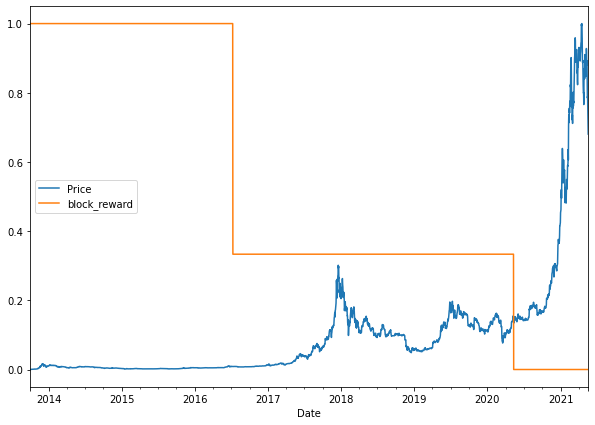

In [55]:
from sklearn.preprocessing import minmax_scale

bitcoin_scale = pd.DataFrame(minmax_scale(bitcoin_prices[['Price', 'block_reward']]), columns=bitcoin_prices.columns, index=bitcoin_prices.index)
bitcoin_scale.plot(figsize=(10,7));

In [56]:
# make windowing with pandas
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_windowed = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_windowed[f'Price+{i+1}'] = bitcoin_windowed['Price'].shift(periods=i+1) # shife down for i+1 row

bitcoin_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25.0,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25.0,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25.0,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25.0,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [57]:
X = bitcoin_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_windowed.dropna()['Price'].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [58]:
train_size = int(len(bitcoin_windowed) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train.shape, y_train.shape

((2229, 8), (2229,))

## Model 6 : Dense (multivariate time series)

In [59]:
tf.random.set_seed(42)
inputs = keras.Input(shape=(8,))
x = keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(1)(x)
model_6 = keras.Model(inputs, outputs, name='multivariate_model6')
model_6.summary()

Model: "multivariate_model6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_10 (Dense)            (None, 128)               1152      
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [60]:
model_6.compile(loss='mae', optimizer='adam', metrics=['mae','mse'])
model_6.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), verbose=0,callbacks=[crete_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


INFO:tensorflow:Assets written to: model_experiment\multivariate_model6\assets


In [61]:
model_6 = tf.keras.models.load_model('model_experiment\multivariate_model6')
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 986us/step - loss: 575.5084 - mae: 575.5084 - mse: 1183149.1250


[575.5084228515625, 575.5084228515625, 1183149.125]

In [62]:
y_preds = model_6.predict(X_test).reshape(-1,)
model_6_score = evaluate_score(y_true=y_test.to_numpy().reshape(-1,1), y_pred=y_preds.reshape(-1,1))
model_6_score

{'mae': 575.5085,
 'mse': 1183149.5,
 'rmse': 1087.7268,
 'mape': 0.02566463,
 'mase': 1.0044637}

## Model 7 : N-BEASTS

create N-BEASTS custom layers, becuase it doesn't exist in tensorflow.

In [63]:
class NBeastBlock(tf.keras.layers.Layer) : # create a new layers
    def __init__(self, input_size: int , 
                 theta_size: int, horizon: int, 
                 n_neurons: int, n_layer: int, **kwargs) :
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layer = n_layer

        #block contains : 4stack of Dense (relu)
        self.hidden = [ tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layer) ]
        #output of block is a theta (linear)
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name = 'theta')

    # work when we call the layer
    def call(self, inputs) :
        x = inputs
        for layer in self.hidden :
            x = layer(x) 
            
        theta = self.theta_layer(x)
        # output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast # x_hat, y_hat

Let's test our NBeastBlock

In [64]:
WINDOW_SIZE = 7
HORIZON = 1

tf.random.set_seed(42)
block_layer = NBeastBlock(input_size = WINDOW_SIZE, 
                          theta_size = WINDOW_SIZE + HORIZON, # all of windowsize and horizon
                          horizon = HORIZON, n_neurons = 128,  
                          n_layer = 4)

dummy_input = tf.expand_dims(tf.range(WINDOW_SIZE) + 1 , axis=0) # start from 1
dummy_input

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [65]:
#pass to block_layer
bc, fc = block_layer(dummy_input)  #go to .call 
print('backcast :',bc.numpy()[0])
print('forecast :',fc.numpy()[0])

backcast : [ 0.07960145  0.32512054 -0.8428684  -0.6938983  -0.3172055  -0.56987345
 -0.63966614]
forecast : [1.0071648]


### Prepare the data with tf.data

In [66]:
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25.0
2013-10-02,125.45500,25.0
2013-10-03,108.58483,25.0
2013-10-04,118.67466,25.0
2013-10-05,121.33866,25.0


In [67]:
bitcoin_prices_nbeats = bitcoin_prices[['Price']].copy()
for i in range(WINDOW_SIZE) :
    bitcoin_prices_nbeats[f'Price+{i+1}'] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [68]:
#make feature and label
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

#split train and test sets
train_size = int(len(X) * .8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train.shape, y_train.shape

((2224, 7), (2224,))

In [69]:
# using with tf.data API for faster training
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS alforithm

In [70]:
#values from the N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

In [138]:
# make tensors
t1 = tf.range(10) + 10
t2 = tf.range(10)

# add or subtract by exact single index
s = keras.layers.subtract([t1, t2])  #subtract
a = keras.layers.add([t1, t2]) # add

print(t1.numpy(), t2.numpy())
print(s.numpy(), a.numpy())

[10 11 12 13 14 15 16 17 18 19] [0 1 2 3 4 5 6 7 8 9]
[10 10 10 10 10 10 10 10 10 10] [10 12 14 16 18 20 22 24 26 28]


In [153]:
%%time
from tensorflow.keras import layers
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeastBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layer=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeastBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeastBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layer=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 334: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 434: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Wall time: 17min 24s


In [154]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 194ms/step - loss: 581.6524 - mae: 581.6524 - mse: 1160523.2500


[581.6524047851562, 581.6524047851562, 1160523.25]

In [155]:
# Make predictions with N-BEATS model
model_7_preds = model_7.predict(test_dataset) 
model_7_preds[:10]

array([[8909.728],
       [8859.439],
       [9018.91 ],
       [8825.914],
       [8812.498],
       [8788.645],
       [8667.781],
       [8560.825],
       [8523.063],
       [8538.944]], dtype=float32)

In [175]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_score(y_true=y_test.to_numpy().reshape(-1,1),
                                 y_pred=model_7_preds)
model_7_results

{'mae': 581.6524395437998,
 'mse': 1160523.313939543,
 'rmse': 1077.2758764307048,
 'mape': 0.027234399644146298,
 'mase': 1.0218021266282213}

## Model 8 : ensemble model
wisdom of the crowd

In [176]:
HORIZON, WINDOW_SIZE

(1, 7)

In [179]:
model_1.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [182]:
def get_emsembles(horizon=HORIZON,train_data=train_dataset, 
                  test_data=test_dataset, num_iter=10, num_epochs=1000,
                  loss_fns = ['mae', 'mse', 'mape']) :
                  
  ensemble_models = []
  for i in range(num_iter) :
    # build and fit a new model with different loss function
    for loss in loss_fns :
        print(f'Optimizing model by reducting: {loss} for {num_epochs} epochs, model_number: {i}')
        # construct a simple model (like model_1)
        model = tf.keras.Sequential([ 
          tf.keras.layers.Input(shape=(7,)),
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'), # type of pattern initalize
          layers.Dense(1,)
        ])
        model.compile(loss=loss, optimizer='adam', metrics=['mae', 'mse'])
        model.fit(train_data, validation_data = test_data, epochs=num_epochs, verbose=0, 
                  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)])

        ensemble_models.append(model)
    
  return ensemble_models

> ReduceLROnPlateau : Reduce learning rate when a metric has stopped improving.

In [ ]:
%%time 
# get list of trained emsemble models
ensemble_models = get_emsembles(num_iter=5, num_epochs=1000)

In [184]:
len(ensemble_models), ensemble_models[:5]

(15,
  <keras.engine.sequential.Sequential at 0x1a10171dde0>])

### Make Prediction with our emsemble model

In [185]:
#create a function to prediction an emsemble model
def pred_emsemble(models, data):
    predictions = []
    for model in models :
        preds = model.predict(data)
        predictions.append(preds)
    return tf.constant(tf.squeeze(predictions))

In [187]:
%%time
ensembles_prediction  = pred_emsemble(ensemble_models, test_dataset)

Wall time: 192 ms


In [191]:
ensembles_prediction.shape

TensorShape([15, 556])

In [195]:
ensembles_prediction[0,:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8792.378, 8814.144, 9077.244, 8711.219, 8805.947, 8729.927,
       8671.59 , 8492.864, 8479.085, 8535.123], dtype=float32)>

In [239]:
# evaluate ensemble model predictions by combine mean or median predicted value
ensemble_mean = np.mean(ensembles_prediction, axis=0)
ensemble_mean[:5], ensemble_mean.shape

(array([8796.204 , 8788.571 , 9068.572 , 8721.651 , 8745.1875],
       dtype=float32),
 (556,))

In [240]:
ensemble_result = evaluate_score(y_test.to_numpy().reshape(-1,1), ensemble_mean.reshape(-1,1))
ensemble_result

{'mae': 567.9125824076062,
 'mse': 1150116.9271807435,
 'rmse': 1072.4350456697803,
 'mape': 0.025553808270394173,
 'mase': 0.9976650057518059}

## Ploting prediction intervals (insted of the dot)
range(min, max)

In [244]:
def get_upper_lower(preds) :
    # axis = 0 , by column
    std = np.std(preds, axis=0) # find standard diviation
    # multipy by 1.96 (95% percent of normal distribution)
    interval = 1.96 * std
    preds_mean = np.mean(preds, axis=0)
    lower, upper = preds_mean-interval, preds_mean+interval

    return lower, upper

In [245]:
lower, upper = get_upper_lower(ensembles_prediction)
lower.shape, upper.shape

((556,), (556,))

In [257]:
X_test.index[:5]

DatetimeIndex(['2019-11-10', '2019-11-11', '2019-11-12', '2019-11-13',
               '2019-11-14'],
              dtype='datetime64[ns]', name='Date', freq=None)

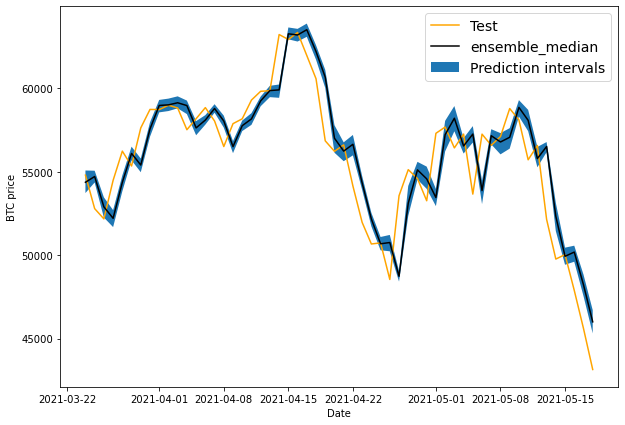

In [274]:
# get the median or mean values of our ensmeble preds
ensemble_median = np.median(ensembles_prediction, axis=0) # by column

offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], c='orange', label='Test')
plt.plot(X_test.index[offset:], ensemble_median[offset:], c= 'black', label='ensemble_median')
plt.xlabel('Date')
plt.ylabel('BTC price')
plt.fill_between(X_test.index[offset:], (lower)[offset:], (upper)[offset:],label='Prediction intervals')
plt.legend(fontsize=14);

### uncertainty in Machine Learning
fit the dog image to model that train by food images ?
- aleatoric : i.e. subway (delayed, noise) -> cannot reduced with more data
- epistemic : i.e. coconut 

## Future Prediction 

In [276]:
bitcoin_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [277]:
X_all = bitcoin_windowed.dropna().drop(['Price','block_reward'], axis=1).to_numpy()
y_all = bitcoin_windowed.dropna()['Price'].to_numpy()
X_all.shape, y_all.shape

((2780, 7), (2780,))

In [279]:
X_all = tf.data.Dataset.from_tensor_slices(X_all)
y_all = tf.data.Dataset.from_tensor_slices(y_all)

data_all = tf.data.Dataset.zip((X_all, y_all)).batch(1024).prefetch(tf.data.AUTOTUNE)
data_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [280]:
tf.random.set_seed(42)

In [ ]:
model_9 = keras.Sequential([
    layers.Input(shape=(7,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model_9.compile(loss='mae', optimizer='adam')
model_9.fit(data_all, epochs=100)

In [284]:
model_9.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1256 (Dense)          (None, 128)               1024      
                                                                 
 dense_1257 (Dense)          (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [288]:
INTO_FUTURE = 14 # next 2 weeks

In [292]:
def make_future_forecasts(values, model, into_future, window_size) :
    future_forecast = []
    last_window = values[-WINDOW_SIZE:] # last 7 day

    for _ in range(into_future):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Days {_ + 1} Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
        future_forecast.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:] # get update the last 7 day frome prediction

    return future_forecast

In [295]:
future_forecast = make_future_forecasts(bitcoin_windowed.dropna()['Price'].to_numpy(), model_9, INTO_FUTURE, 7)

Days 1 Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 54248.7421875

Days 2 Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 54248.7421875 ] -> Prediction: 50358.83984375

Days 3 Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 54248.7421875  50358.83984375] -> Prediction: 48919.91796875

Days 4 Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 54248.7421875  50358.83984375 48919.91796875] -> Prediction: 48486.6015625

Days 5 Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 54248.7421875
 50358.83984375 48919.91796875 48486.6015625 ] -> Prediction: 47751.05078125

Days 6 Predicting on: 
 [45604.61575361 43144.47129086 54248.7421875  50358.83984375
 48919.91796875 48486.6015625  47751.05078125] -> Prediction: 46696.72265625

Days 7 Predicting on: 
 [

In [294]:
future_forecast # next 2 weeks

[54248.742,
 50358.84,
 48919.918,
 48486.6,
 47751.05,
 46696.723,
 47679.777,
 52061.535,
 49276.504,
 48464.74,
 48268.66,
 48162.164,
 47983.86,
 49189.055]

In [296]:
def get_future_dates(start_date, into_future, offset=1):
    start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
    end_date = start_date + np.timedelta64(into_future, "D") # specify end date
    return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range bet

In [297]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [298]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [299]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [302]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep) # insert last_timestep to index0 in next_time_steps
future_forecast = np.insert(future_forecast, 0, bitcoin_prices['Price'][-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 54248.742, 50358.84 , 48919.918, 48486.6  , 47751.05 ,
        46696.723, 47679.777, 52061.535, 49276.504, 48464.74 , 48268.66 ,
        48162.164, 47983.86 , 49189.055], dtype=float32))

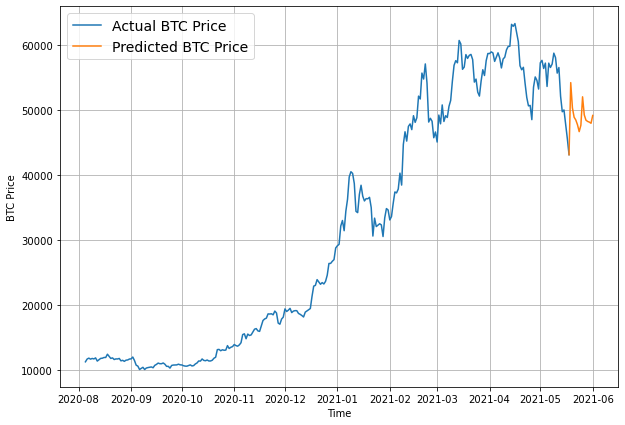

In [303]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, bitcoin_prices['Price'], start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")